In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import NearMiss
from collections import Counter
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=UserWarning, module="joblib")
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
warnings.filterwarnings('ignore', category=UserWarning, message="Line Search failed")

In [4]:
#load data and preprocess
data = pd.read_csv('/content/drive/My Drive/ML_project/labelled_data.csv').fillna(0)
print(data.head())
print(data.isnull().sum())

   Unnamed: 0     Name        FC     logFC    logCPM   P-Value       FDR  \
0           0  KRT16P5 -1.474275 -0.560006 -2.065784  0.423250  0.645529   
1           1  KRT16P3 -1.158475 -0.212227  0.698547  0.598622  0.779482   
2           2  KRT16P2  1.785481  0.836313  3.744968  0.060200  0.211667   
3           3  KRT16P6 -2.534136 -1.341494  0.404997  0.023716  0.123727   
4           4    CRHBP  1.441891  0.527962 -0.015277  0.034942  0.153404   

   SCLC  NSCLC  
0   0.0    0.0  
1   0.0    0.0  
2   0.0    0.0  
3   0.0    0.0  
4   0.0    0.0  
Unnamed: 0    0
Name          0
FC            0
logFC         0
logCPM        0
P-Value       0
FDR           0
SCLC          0
NSCLC         0
dtype: int64


In [5]:
print(data.shape)
print()
print(data.describe)
print()
print(data.info)
print()
print(data.duplicated())
print()
print(data.dtypes)

(19778, 9)

<bound method NDFrame.describe of        Unnamed: 0          Name        FC     logFC    logCPM   P-Value  \
0               0       KRT16P5 -1.474275 -0.560006 -2.065784  0.423250   
1               1       KRT16P3 -1.158475 -0.212227  0.698547  0.598622   
2               2       KRT16P2  1.785481  0.836313  3.744968  0.060200   
3               3       KRT16P6 -2.534136 -1.341494  0.404997  0.023716   
4               4         CRHBP  1.441891  0.527962 -0.015277  0.034942   
...           ...           ...       ...       ...       ...       ...   
19773       19773  LOC105369958  2.196994  1.135531  1.382694  0.003199   
19774       19774         ABCC2  3.461301  1.791314  5.336636  0.000671   
19775       19775         TRAV6  3.849574  1.944699 -0.401490  0.000016   
19776       19776  LOC105369904  2.226049  1.154485 -1.006838  0.002616   
19777       19777  LOC101928636  2.279563  1.188757  0.151617  0.000219   

            FDR  SCLC  NSCLC  
0      0.645529   0.0 

In [6]:
print(data.columns[data.isna().any()])
print()

Index([], dtype='object')



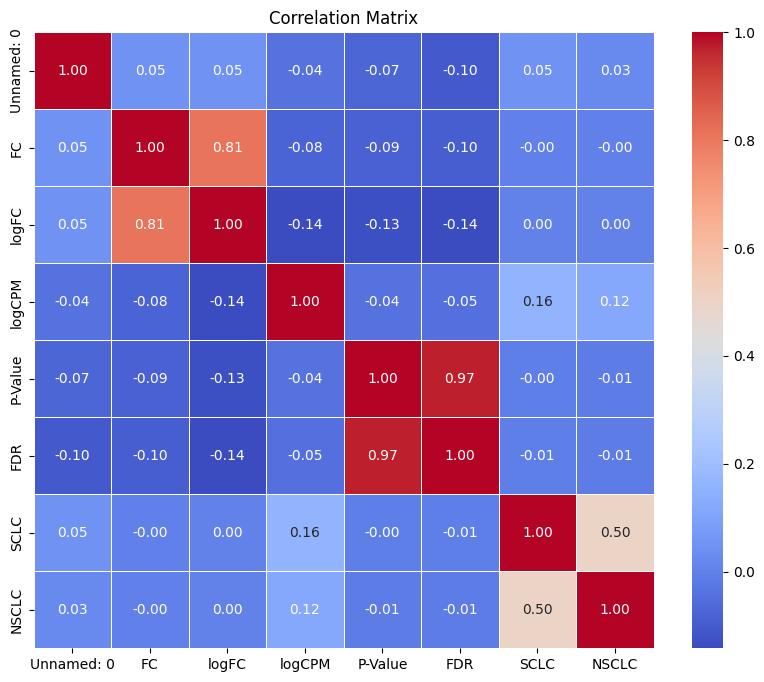

In [8]:
correlation_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix")
plt.show()

In [9]:
#feature selection
features = data[['FC', 'logFC', 'P-Value']]
targets = {'NSCLC': data['NSCLC'], 'SCLC': data['SCLC']}

In [10]:
nsclc = data['NSCLC']
sclc = data['SCLC']

In [13]:
nm = NearMiss()
print('SCLC Original Shape:', Counter(sclc))
features_nm_sclc, nm_sclc = nm.fit_resample(features, sclc)
print('SCLC Resample Shape:', Counter(nm_sclc))
print('NSCLC Original Shape:', Counter(nsclc))
features_nm_nsclc, nm_nsclc = nm.fit_resample(features, nsclc)
print('NSCLC Resample Shape:', Counter(nm_nsclc))

SCLC Original Shape: Counter({0.0: 18857, 1.0: 921})
SCLC Resample Shape: Counter({0.0: 921, 1.0: 921})
NSCLC Original Shape: Counter({0.0: 19087, 1.0: 691})
NSCLC Resample Shape: Counter({0.0: 691, 1.0: 691})


In [14]:
features_sclc = features_nm_sclc
features_nsclc = features_nm_nsclc
sclc = nm_sclc
nsclc = nm_nsclc

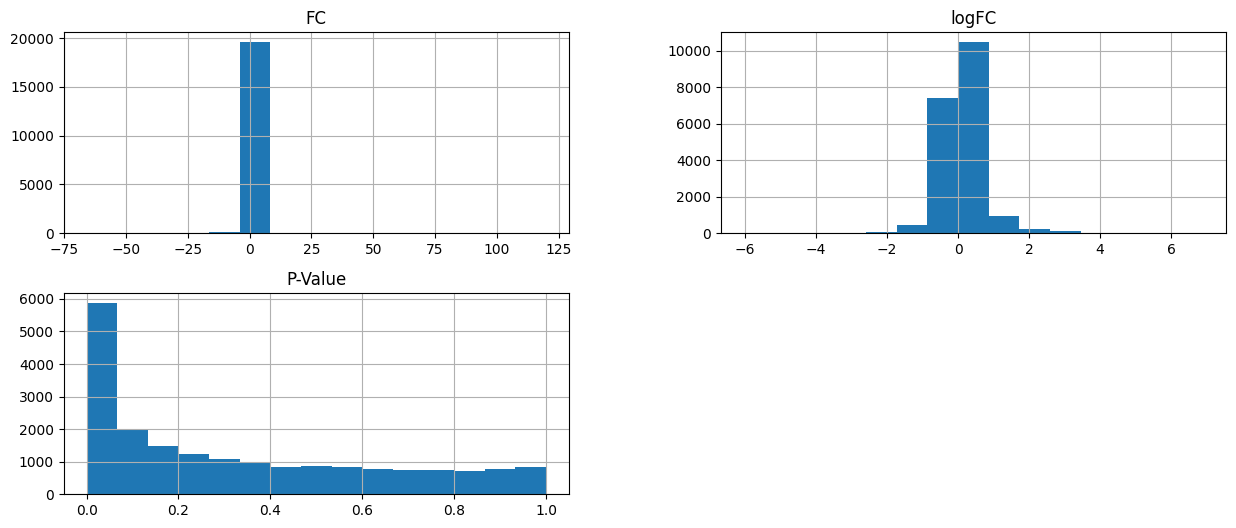

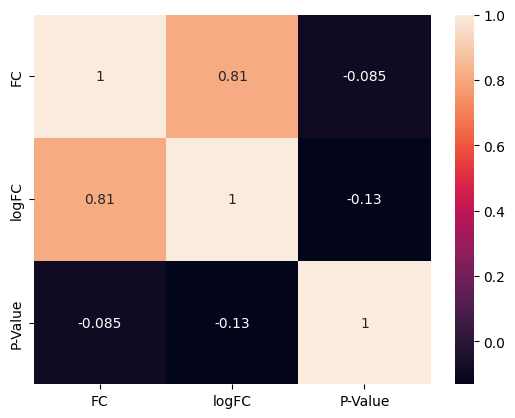

In [15]:
#histograms and correlation matrix
features.hist(bins=15, figsize=(15, 6), layout=(2, 2))
plt.show()
sns.heatmap(features.corr(), annot=True)
plt.show()

In [16]:
def train_test_and_standardize(features, target, test_size=0.2, random_state=42):
    # Split the data into train and test sets
    x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=test_size, random_state=random_state)

    # Standardize the features using StandardScaler
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    return x_train, x_test, y_train, y_test

In [17]:
xtrain_sclc, xtest_sclc, ytrain_sclc, ytest_sclc = train_test_and_standardize(features_sclc, sclc)
xtrain_nsclc, xtest_nsclc, ytrain_nsclc, ytest_nsclc = train_test_and_standardize(features_nsclc, nsclc)

In [27]:
#logistic regression pipeline
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(class_weight='balanced', max_iter=10000))
])

#parameter grid for Logistic Regression
param_grid_lr = [
    {'lr__penalty': ['l1', 'l2'], 'lr__C': np.logspace(-4, 4, 10), 'lr__solver': ['liblinear'], 'lr__tol': [1e-3],'lr__fit_intercept': [True, False],
     'lr__class_weight': [None, 'balanced'], 'lr__random_state': [None], 'lr__max_iter': [5000, 10000, 15000],
      'lr__multi_class': ['auto', 'ovr', 'multinomial'], 'lr__verbose': [0], 'lr__warm_start': [True, False],'lr__n_jobs': [None, -1]},
    {'lr__penalty': ['l2'], 'lr__C': np.logspace(-4, 4, 10), 'lr__solver': ['lbfgs', 'newton-cg', 'sag'], 'lr__tol': [1e-3],'lr__fit_intercept': [True, False],
      'lr__class_weight': [None, 'balanced'], 'lr__random_state': [None], 'lr__max_iter': [5000, 10000, 15000],
      'lr__multi_class': ['auto', 'ovr', 'multinomial'], 'lr__verbose': [0], 'lr__warm_start': [True, False],'lr__n_jobs': [None, -1]},
    {'lr__penalty': ['elasticnet'], 'lr__C': np.logspace(-4, 4, 10), 'lr__solver': ['saga'], 'lr__l1_ratio': np.linspace(0, 1, 10), 'lr__tol': [1e-3],'lr__fit_intercept': [True, False],
      'lr__class_weight': [None, 'balanced'], 'lr__random_state': [None], 'lr__max_iter': [5000, 10000, 15000],
      'lr__multi_class': ['auto', 'ovr', 'multinomial'], 'lr__verbose': [0], 'lr__warm_start': [True, False],'lr__n_jobs': [None, -1]}
]


In [28]:
def evaluate_lr(x_train, y_train, x_test, y_test, param_grid):
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid_lr, scoring='f1', cv=5, verbose=1, n_jobs=-1)
    grid_search.fit(x_train, y_train)  #fit on training data
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_lr = pipeline.set_params(**best_params)
    best_lr.fit(x_train, y_train)  #refit on training data
    y_test_pred = best_lr.predict(x_test)
    report = classification_report(y_test, y_test_pred)
    return best_params, best_score, report


In [29]:
best_params_nsclc, best_score_nsclc, report_nsclc = evaluate_lr(xtrain_nsclc, ytrain_nsclc, xtest_nsclc, ytest_nsclc, param_grid_lr)
print("Best Parameters for NSCLC:", best_params_nsclc)
print("Best F1 Score for NSCLC:", best_score_nsclc)
print("Classification Report for NSCLC (Test Data):\n", report_nsclc)

Fitting 5 folds for each of 21600 candidates, totalling 108000 fits
Best Parameters for NSCLC: {'lr__C': 0.0001, 'lr__class_weight': None, 'lr__fit_intercept': True, 'lr__max_iter': 10000, 'lr__multi_class': 'auto', 'lr__n_jobs': -1, 'lr__penalty': 'l2', 'lr__random_state': None, 'lr__solver': 'sag', 'lr__tol': 0.001, 'lr__verbose': 0, 'lr__warm_start': False}
Best F1 Score for NSCLC: 0.8068794072621254
Classification Report for NSCLC (Test Data):
               precision    recall  f1-score   support

         0.0       0.82      0.73      0.77       142
         1.0       0.74      0.84      0.79       135

    accuracy                           0.78       277
   macro avg       0.78      0.78      0.78       277
weighted avg       0.78      0.78      0.78       277



In [30]:
best_params_sclc, best_score_sclc, report_sclc = evaluate_lr(xtrain_sclc, ytrain_sclc, xtest_sclc, ytest_sclc, param_grid_lr)
print("Best Parameters for SCLC:", best_params_sclc)
print("Best F1 Score for SCLC:", best_score_sclc)
print("Classification Report for SCLC (Test Data):\n", report_sclc)

Fitting 5 folds for each of 21600 candidates, totalling 108000 fits
Best Parameters for SCLC: {'lr__C': 0.0001, 'lr__class_weight': None, 'lr__fit_intercept': True, 'lr__max_iter': 5000, 'lr__multi_class': 'ovr', 'lr__n_jobs': -1, 'lr__penalty': 'l2', 'lr__random_state': None, 'lr__solver': 'sag', 'lr__tol': 0.001, 'lr__verbose': 0, 'lr__warm_start': False}
Best F1 Score for SCLC: 0.7635247723067767
Classification Report for SCLC (Test Data):
               precision    recall  f1-score   support

         0.0       0.74      0.68      0.71       188
         1.0       0.69      0.75      0.72       181

    accuracy                           0.71       369
   macro avg       0.71      0.71      0.71       369
weighted avg       0.71      0.71      0.71       369

